In [1]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install keras
%pip install optuna


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.Collecting optuna
  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/a0/8c/f72c6bc61b3c71149af95cd91e16149ea5b5aeae99e6d197f80e79a1035a/optuna-3.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/11/00/46a4f66ad54c661350a1cd5daae4b4ab2232486c55635ee12ff12958b03f/alembic-1.11.1-py3-none-any.whl.metadata
  Obtaining dependency information for cmaes>=0.9.1 from https://files.pythonhosted.org/packages/f7/46/7d9544d453346f6c0c405916c95fdb653491ea2e9976cabb810ba2fe8cd4/cmaes-0.10.0-py3-none-any.whl.metadata
     -------------------------------------- 78.7/78.7 kB 400.2 kB/s eta 0:00:00
   -------------------------------------- 390.6/390.6 kB 716.3 kB/s eta 0:00:00
   ---------------------------------------- 224.5/224.5 kB 1.5 MB/s eta 0:00:00



  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging
import optuna



In [5]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [6]:
import yfinance as yf
vgt_data = yf.download("VGT", period = '5y')
voo_data = yf.download("VOO", period = '5y')
spy_data = yf.download('SPY', period = '5y')
data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
#SIMPLE 80:20 SPLIT

split_index = int(len(data) * 0.8)
train_df = data[:split_index]
val_df = data[split_index:]

In [7]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [95]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=1000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=1000)

    logger.info('Training is complete')

    envs = [val_env1, val_env2, val_env3]

    def evalModel():

        num_years = 3
        counter = 3

        while counter <= num_years:

            for i in envs:
                ppo_rewards = []
                obs1 = i.reset()

                while True:
                    action, _ = ppo_agent.predict(obs1)
                    logger.info(f'PPO Took action {action} in state {obs1}')
                    obs, reward, done, info = i.step(action)
                    ppo_rewards.append(reward)

                    if done:
                        break

                print(f'PPO average validation for year {counter} reward: ', np.mean(ppo_rewards))


                a2c_rewards = []
                obs2 = val_env1.reset()

                while True:
                    action, _ = a2c_agent.predict(obs2)
                    obs, reward, done, info = val_env1.step(action)
                    a2c_rewards.append(reward)

                    if done:
                        break

                print(f'A2C average validation for year {counter} reward: ', np.mean(a2c_rewards))

                if np.mean(ppo_rewards) > np.mean(a2c_rewards):
                    agent = ppo_agent
                    action, _ = agent.predict(obs1)
                    print(f'Agent chosen for year {counter} is PPO')
                else:
                    agent = a2c_agent
                    action, _ = agent.predict(obs2)
                    print(f'Agent chosen for year {counter} is A2C')

                counter += 1
            

        



        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        #plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()
    evalModel()

    




C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\l

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 35.5     |
| time/              |          |
|    fps             | 2199     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1092     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.632   |
|    explained_variance | 4.77e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.176   |
|    value_loss         | 2.

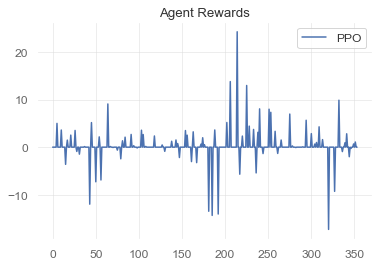

In [96]:
ModelCreation()

In [40]:
window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
        'stocks-v0',
        df = train_df,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

val_env1 = gym.make(
    'stocks-v0',
    df = val_df_1,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)




val_env2 = gym.make(
    'stocks-v0',
    df = val_df_2,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



val_env3 = gym.make(
    'stocks-v0',
    df = val_df_3,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])


n_cpu = 4

def optimizePPO(trial):
    return {
        'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
        'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
        'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
        'clip_range': trial.suggest_uniform('cliprange', 0.1, 0.4),
        'n_epochs' : int(trial.suggest_loguniform('noptepochs', 1, 48)),
        'gae_lambda': trial.suggest_uniform('lam', 0.8, 1.)
    }

n_steps = 0

def optimize_agent(trial):
    model_params = optimizePPO(trial)
    env = env1
    model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
    model.learn(10000)

    rewards = []
    global n_steps

    n_episodes, reward_sum = 0, 0.0

    obs = env.reset()
    while n_episodes < 4:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        reward_sum += reward

        if done.all():
            rewards.append(reward_sum)
            reward_sum = 0.0
            n_episodes += 1
            obs = env.reset()

    last_reward = np.mean(rewards)
    trial.report(-1 * last_reward, step = n_steps)

    return -1 * last_reward

    

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [39]:
study = optuna.create_study()
study.optimize(optimize_agent, n_trials = 5)



[I 2023-07-28 14:24:49,716] A new study created in memory with name: no-name-c9bbd278-17d2-4938-bc27-b45ba26cb65e
C:\Users\12016\AppData\Local\Temp\ipykernel_22200\3318553121.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
C:\Users\12016\AppData\Local\Temp\ipykernel_22200\3318553121.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_22200\3318553121.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 719      |
|    ep_rew_mean     | 166      |
| time/              |          |
|    fps             | 2289     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1669     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 719          |
|    ep_rew_mean          | 173          |
| time/                   |              |
|    fps                  | 760          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 3338         |
| train/                  |              |
|    approx_kl            | 0.0031446794 |
|    clip_fraction        | 0.0597       |
|    clip_range           | 0.104        |
|    en

[I 2023-07-28 14:31:46,958] Trial 0 finished with value: -1679.819580078125 and parameters: {'n_steps': 1669.9083536358685, 'gamma': 0.9935576208285933, 'learning_rate': 0.00032238888306693485, 'ent_coef': 1.3804572856917124e-06, 'cliprange': 0.10436692673788413, 'noptepochs': 42.771075852033285, 'lam': 0.9766306962347859}. Best is trial 0 with value: -1679.819580078125.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2247 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 455  |
-----------------------------


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 455`, after every 7 untruncated mini-batches, there will be a truncated mini-batch of size 7
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=455 and n_envs=1)
  warnings.warn(


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 719       |
|    ep_rew_mean          | 68        |
| time/                   |           |
|    fps                  | 2167      |
|    iterations           | 2         |
|    time_elapsed         | 0         |
|    total_timesteps      | 910       |
| train/                  |           |
|    approx_kl            | 34.877457 |
|    clip_fraction        | 0.875     |
|    clip_range           | 0.334     |
|    entropy_loss         | -0.0891   |
|    explained_variance   | 4.78e-05  |
|    learning_rate        | 0.409     |
|    loss                 | 186       |
|    n_updates            | 1         |
|    policy_gradient_loss | 0.256     |
|    value_loss           | 163       |
---------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 719       |
|    ep_rew_mean          | 68        |


[I 2023-07-28 14:38:15,793] Trial 1 finished with value: -0.0 and parameters: {'n_steps': 455.30293656760387, 'gamma': 0.9253744546768384, 'learning_rate': 0.40875527189975164, 'ent_coef': 0.0026074984604983636, 'cliprange': 0.33387669466633463, 'noptepochs': 1.7519004749247884, 'lam': 0.9275929599498923}. Best is trial 0 with value: -1679.819580078125.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2164 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 136  |
-----------------------------


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 136`, after every 2 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=136 and n_envs=1)
  warnings.warn(


---------------------------------------
| time/                   |           |
|    fps                  | 762       |
|    iterations           | 2         |
|    time_elapsed         | 0         |
|    total_timesteps      | 272       |
| train/                  |           |
|    approx_kl            | 6.4909854 |
|    clip_fraction        | 0.874     |
|    clip_range           | 0.347     |
|    entropy_loss         | -0.249    |
|    explained_variance   | 0.000317  |
|    learning_rate        | 0.0289    |
|    loss                 | 15.3      |
|    n_updates            | 29        |
|    policy_gradient_loss | 0.123     |
|    value_loss           | 36        |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 631       |
|    iterations           | 3         |
|    time_elapsed         | 0         |
|    total_timesteps      | 408       |
| train/                  |           |


[I 2023-07-28 14:44:59,930] Trial 2 finished with value: -0.0 and parameters: {'n_steps': 136.67018930985253, 'gamma': 0.9772109486308755, 'learning_rate': 0.02891085424239648, 'ent_coef': 7.2398006497274326e-06, 'cliprange': 0.3467087177357294, 'noptepochs': 29.525071312270804, 'lam': 0.9780467872943273}. Best is trial 0 with value: -1679.819580078125.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2048 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 47   |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1545          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 94            |
| train/                  |               |
|    approx_kl            | 0.00012231887 |
|    clip_fraction        | 0             |
|    clip_range           | 0.308         |
|    entropy_loss         | -0.693        |
|    explained_variance   | 0.00261       |
|    learning_rate        | 9.98e-05      |
|    loss                 | 4.55          |
|    n_updates            | 5             |
|    policy_gradient_loss | -0.00051

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 47`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 47
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=47 and n_envs=1)
  warnings.warn(


------------------------------------------
| time/                   |              |
|    fps                  | 1311         |
|    iterations           | 6            |
|    time_elapsed         | 0            |
|    total_timesteps      | 282          |
| train/                  |              |
|    approx_kl            | 8.735124e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.308        |
|    entropy_loss         | -0.69        |
|    explained_variance   | 0.000222     |
|    learning_rate        | 9.98e-05     |
|    loss                 | 6.31         |
|    n_updates            | 25           |
|    policy_gradient_loss | -0.000103    |
|    value_loss           | 12.6         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1301          |
|    iterations           | 7             |
|    time_elapsed         | 0             |
|    t

[I 2023-07-28 14:51:50,822] Trial 3 finished with value: -2810.1640625 and parameters: {'n_steps': 47.69492578331755, 'gamma': 0.9210157662984991, 'learning_rate': 9.977870235715527e-05, 'ent_coef': 7.971129466598355e-06, 'cliprange': 0.3076116027483111, 'noptepochs': 5.248265181259201, 'lam': 0.9777987276354275}. Best is trial 3 with value: -2810.1640625.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2137 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 211  |
-----------------------------


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 211`, after every 3 untruncated mini-batches, there will be a truncated mini-batch of size 19
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=211 and n_envs=1)
  warnings.warn(


---------------------------------------
| time/                   |           |
|    fps                  | 746       |
|    iterations           | 2         |
|    time_elapsed         | 0         |
|    total_timesteps      | 422       |
| train/                  |           |
|    approx_kl            | 63.67835  |
|    clip_fraction        | 0.993     |
|    clip_range           | 0.299     |
|    entropy_loss         | -0.0051   |
|    explained_variance   | -3.58e-07 |
|    learning_rate        | 0.684     |
|    loss                 | 2.45      |
|    n_updates            | 34        |
|    policy_gradient_loss | 0.264     |
|    value_loss           | 55.3      |
---------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 617      |
|    iterations           | 3        |
|    time_elapsed         | 1        |
|    total_timesteps      | 633      |
| train/                  |          |
|    ap

[I 2023-07-28 14:58:35,359] Trial 4 finished with value: -0.0 and parameters: {'n_steps': 211.35908588060013, 'gamma': 0.9369113698691068, 'learning_rate': 0.6835180466902232, 'ent_coef': 0.028660980737557327, 'cliprange': 0.29928558780875325, 'noptepochs': 34.00054313879542, 'lam': 0.8536880235640647}. Best is trial 3 with value: -2810.1640625.


In [40]:
study.best_params

{'n_steps': 47.69492578331755,
 'gamma': 0.9210157662984991,
 'learning_rate': 9.977870235715527e-05,
 'ent_coef': 7.971129466598355e-06,
 'cliprange': 0.3076116027483111,
 'noptepochs': 5.248265181259201,
 'lam': 0.9777987276354275}

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'